In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-NGS-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20240227-DataSheet-RUN54.csv"
run = "run54"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run54-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,Test01-B1_S314,ACGTACGT,CARRGGNYYYGMDVWGQGTTVT,786,117,IGHV4-39,IGHJ6,44,0.055980,0.913231,0.819041
1,Test01-B1_S314,ACGTACGT,CAREDGYYGLDVWGQGTTVT,698,85,IGHV3-48,IGHJ6,24,0.034384,0.810987,0.595030
2,Test01-B1_S314,ACGTACGT,CARDTSWAFDIWGQGTMVT,490,43,IGHV3-48,IGHJ3,0,0.000000,0.569317,0.301015
3,Test01-B1_S314,ACGTACGT,CVKEIEPPGRVRHYGMDVWGQGTTVT,477,61,IGHV3-23,IGHJ6,0,0.000000,0.554213,0.427021
4,Test01-B1_S314,ACGTACGT,CTRGTAGYGRFDPWGQGTLVT,420,71,IGHV3-74,IGHJ5,2,0.004762,0.487986,0.497025


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
982895,Test10-Bp3_S305,CARDHSGFDTWGQGTMVT,957,293,6,0.006270,1.132116,0.754435
998647,Test10-Bp3_S305,CTKDNLYSTGWQDYWGQGTLVT,258,96,4,0.015504,0.305210,0.247187
984471,Test10-Bp3_S305,CARDRFDPWGQGTLVT,170,47,1,0.005882,0.201107,0.121019
982434,Test10-Bp3_S305,CARDGGSGYYPDLGQGTLVT,167,65,4,0.023952,0.197558,0.167366
998479,Test10-Bp3_S305,CITVSYKIVVEVSSAQSSFDPWGQGTLVT,133,67,0,0.000000,0.157337,0.172516


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Chain,Patient,SampleInfo,UMI,Constant,HEK_cells,Group,MID,RACE,ChainOriginal
0,N701_S502,T2B001-J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,...,BCRh,32,HC,yes,no,no,NaN,NaN,yes,BCRh
1,N702_S502,T2B002-J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,...,BCRh,41,HC,yes,no,no,NaN,NaN,yes,BCRh
2,N703_S502,T2B003-J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,...,BCRh,51,HC,yes,no,no,NaN,NaN,yes,BCRh
3,N704_S502,T2B004-J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,...,BCRh,77,HC,yes,no,no,NaN,NaN,yes,BCRh
4,N706_S502,T2B008-J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,...,BCRh,110,PF29,yes,no,no,NaN,NaN,yes,BCRh


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,T2B001-J_S1,32
1,T2B002-J_S2,41
2,T2B003-J_S3,51
3,T2B004-J_S4,77
4,T2B008-J_S5,110


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,Test10-Bp3_S305,CARDHSGFDTWGQGTMVT,957,293,6,0.006270,1.132116,0.754435,Test10
1,Test10-Bp3_S305,CTKDNLYSTGWQDYWGQGTLVT,258,96,4,0.015504,0.305210,0.247187,Test10
2,Test10-Bp3_S305,CARDRFDPWGQGTLVT,170,47,1,0.005882,0.201107,0.121019,Test10
3,Test10-Bp3_S305,CARDGGSGYYPDLGQGTLVT,167,65,4,0.023952,0.197558,0.167366,Test10
4,Test10-Bp3_S305,CITVSYKIVVEVSSAQSSFDPWGQGTLVT,133,67,0,0.000000,0.157337,0.172516,Test10


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                      Test01                                 \
Sample               Test01-B1_S314 Test01-B2_S315 Test01-Bp1_S322   
cdr3pep                                                              
AAAATQNYYMDVWGKGTTVT            0.0            0.0             0.0   
AATRQYWGQGTRVT                  0.0            0.0             0.0   
AFDIWGQGTMVT                    0.0            0.0             0.0   
AHFVVVPAAGDYWGQGTLVT            0.0            0.0             0.0   
AIAAAGPDYWGQGTLVT               0.0            0.0             0.0   

Patient                                      Test03                 \
Sample               Test01-Bp2_S323 Test03-B1_S316 Test03-B2_S317   
cdr3pep                                                              
AAAATQNYYMDVWGKGTTVT             0.0            0.0            0.0   
AATRQYWGQGTRVT                   0.0            0.0            0.0   
AFDIWGQGTMVT                     0.0            0.0            0.0   
AHFVVVPAAGDYWGQGTLVT             0.0            0.0            0.0   
AIAAAGPDYWGQGTLVT                0.0            0.0            0.0   

Patient                                                              \
Sample               Test03-B3_S318 Test03-Bp1_S324 Test03-Bp2_S325   
cdr3pep                                                               
AAAATQNYYMDVWGKGTTVT            0.0             0.0             0.0   
AATRQYWGQGTRVT                  0.0             0.0             0.0   
AFDIWGQGTMVT                    0.0             0.0             0.0   
AHFVVVPAAGDYWGQGTLVT            0.0             0.0             0.0   
AIAAAGPDYWGQGTLVT               0.0             0.0             0.0   

Patient                               ...         Test09                  \
Sample               Test03-Bp3_S326  ... Test09-B3_S368 Test09-Bp1_S374   
cdr3pep                               ...                                  
AAAATQNYYMDVWGKGTTVT             0.0  ...            0.0             0.0   
AATRQYWGQGTRVT                   0.0  ...            7.0             0.0   
AFDIWGQGTMVT                     0.0  ...            0.0             0.0   
AHFVVVPAAGDYWGQGTLVT             0.0  ...            0.0             0.0   
AIAAAGPDYWGQGTLVT                0.0  ...            0.0             0.0   

Patient                                                      Test10  \
Sample               Test09-Bp2_S375 Test09-Bp3_S376 Test10-B1_S369   
cdr3pep                                                               
AAAATQNYYMDVWGKGTTVT             0.0             0.0            0.0   
AATRQYWGQGTRVT                   0.0             0.0            0.0   
AFDIWGQGTMVT                     0.0             0.0            0.0   
AHFVVVPAAGDYWGQGTLVT             0.0             0.0            0.0   
AIAAAGPDYWGQGTLVT                0.0             0.0            0.0   

Patient                                                             \
Sample               Test10-B2_S298 Test10-B3_S299 Test10-Bp1_S377   
cdr3pep                                                              
AAAATQNYYMDVWGKGTTVT            0.0            0.0             0.0   
AATRQYWGQGTRVT                  0.0            0.0             0.0   
AFDIWGQGTMVT                    0.0            0.0             0.0   
AHFVVVPAAGDYWGQGTLVT            0.0            0.0             0.0   
AIAAAGPDYWGQGTLVT               0.0            0.0             0.0   

Patient                                               
Sample               Test10-Bp2_S304 Test10-Bp3_S305  
cdr3pep                                               
AAAATQNYYMDVWGKGTTVT             0.0             0.0  
AATRQYWGQGTRVT                   0.0             0.0  
AFDIWGQGTMVT                     0.0             0.0  
AHFVVVPAAGDYWGQGTLVT             0.0             0.0  
AIAAAGPDYWGQGTLVT                0.0             0.0  

[5 rows x 52 columns]

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                         Test01                                 \
Sample                  Test01-B1_S314 Test01-B2_S315 Test01-Bp1_S322   
Patient Sample                                                          
Test01  Test01-B1_S314        1.000000       0.436789        0.410307   
        Test01-B2_S315        0.436789       1.000000        0.423455   
        Test01-Bp1_S322       0.410307       0.423455        1.000000   
        Test01-Bp2_S323       0.410280       0.420019        0.451279   
Test03  Test03-B1_S316        0.000058       0.000038        0.000080   

Patient                                         Test03                 \
Sample                  Test01-Bp2_S323 Test03-B1_S316 Test03-B2_S317   
Patient Sample                                                          
Test01  Test01-B1_S314         0.410280       0.000058       0.000000   
        Test01-B2_S315         0.420019       0.000038       0.000029   
        Test01-Bp1_S322        0.451279       0.000080       0.000030   
        Test01-Bp2_S323        1.000000       0.000053       0.000045   
Test03  Test03-B1_S316         0.000053       1.000000       0.500200   

Patient                                                                 \
Sample                  Test03-B3_S318 Test03-Bp1_S324 Test03-Bp2_S325   
Patient Sample                                                           
Test01  Test01-B1_S314        0.000000        0.000039        0.000000   
        Test01-B2_S315        0.000012        0.000000        0.000018   
        Test01-Bp1_S322       0.000013        0.000030        0.000019   
        Test01-Bp2_S323       0.000013        0.000091        0.000019   
Test03  Test03-B1_S316        0.496758        0.534271        0.391356   

Patient                                  ...         Test09                  \
Sample                  Test03-Bp3_S326  ... Test09-B3_S368 Test09-Bp1_S374   
Patient Sample                           ...                                  
Test01  Test01-B1_S314         0.000000  ...       0.000044        0.000077   
        Test01-B2_S315         0.000000  ...       0.000012        0.000036   
        Test01-Bp1_S322        0.000016  ...       0.000226        0.000265   
        Test01-Bp2_S323        0.000000  ...       0.000050        0.000063   
Test03  Test03-B1_S316         0.457698  ...       0.000176        0.000452   

Patient                                                         Test10  \
Sample                  Test09-Bp2_S375 Test09-Bp3_S376 Test10-B1_S369   
Patient Sample                                                           
Test01  Test01-B1_S314         0.000051        0.000033       0.000052   
        Test01-B2_S315         0.000000        0.000000       0.000011   
        Test01-Bp1_S322        0.000252        0.000378       0.000307   
        Test01-Bp2_S323        0.000000        0.000050       0.000200   
Test03  Test03-B1_S316         0.000013        0.000044       0.000000   

Patient                                                                \
Sample                  Test10-B2_S298 Test10-B3_S299 Test10-Bp1_S377   
Patient Sample                                                          
Test01  Test01-B1_S314        0.000333       0.000629        0.000107   
        Test01-B2_S315        0.000305       0.000547        0.000000   
        Test01-Bp1_S322       0.001175       0.000821        0.000288   
        Test01-Bp2_S323       0.000598       0.001933        0.000232   
Test03  Test03-B1_S316        0.000054       0.000031        0.000000   

Patient                                                  
Sample                  Test10-Bp2_S304 Test10-Bp3_S305  
Patient Sample                                           
Test01  Test01-B1_S314         0.000009        0.000059  
        Test01-B2_S315         0.000000        0.000000  
        Test01-Bp1_S322        0.000276        0.000298  
        Test01-Bp2_S323        0.000211        0.000243  
Test03  Test03-B1_S3

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run54-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 8.816126458532914e-06
max value: 1.0
Wrote run54-similarity-IGH_HUMAN.pdf to disk


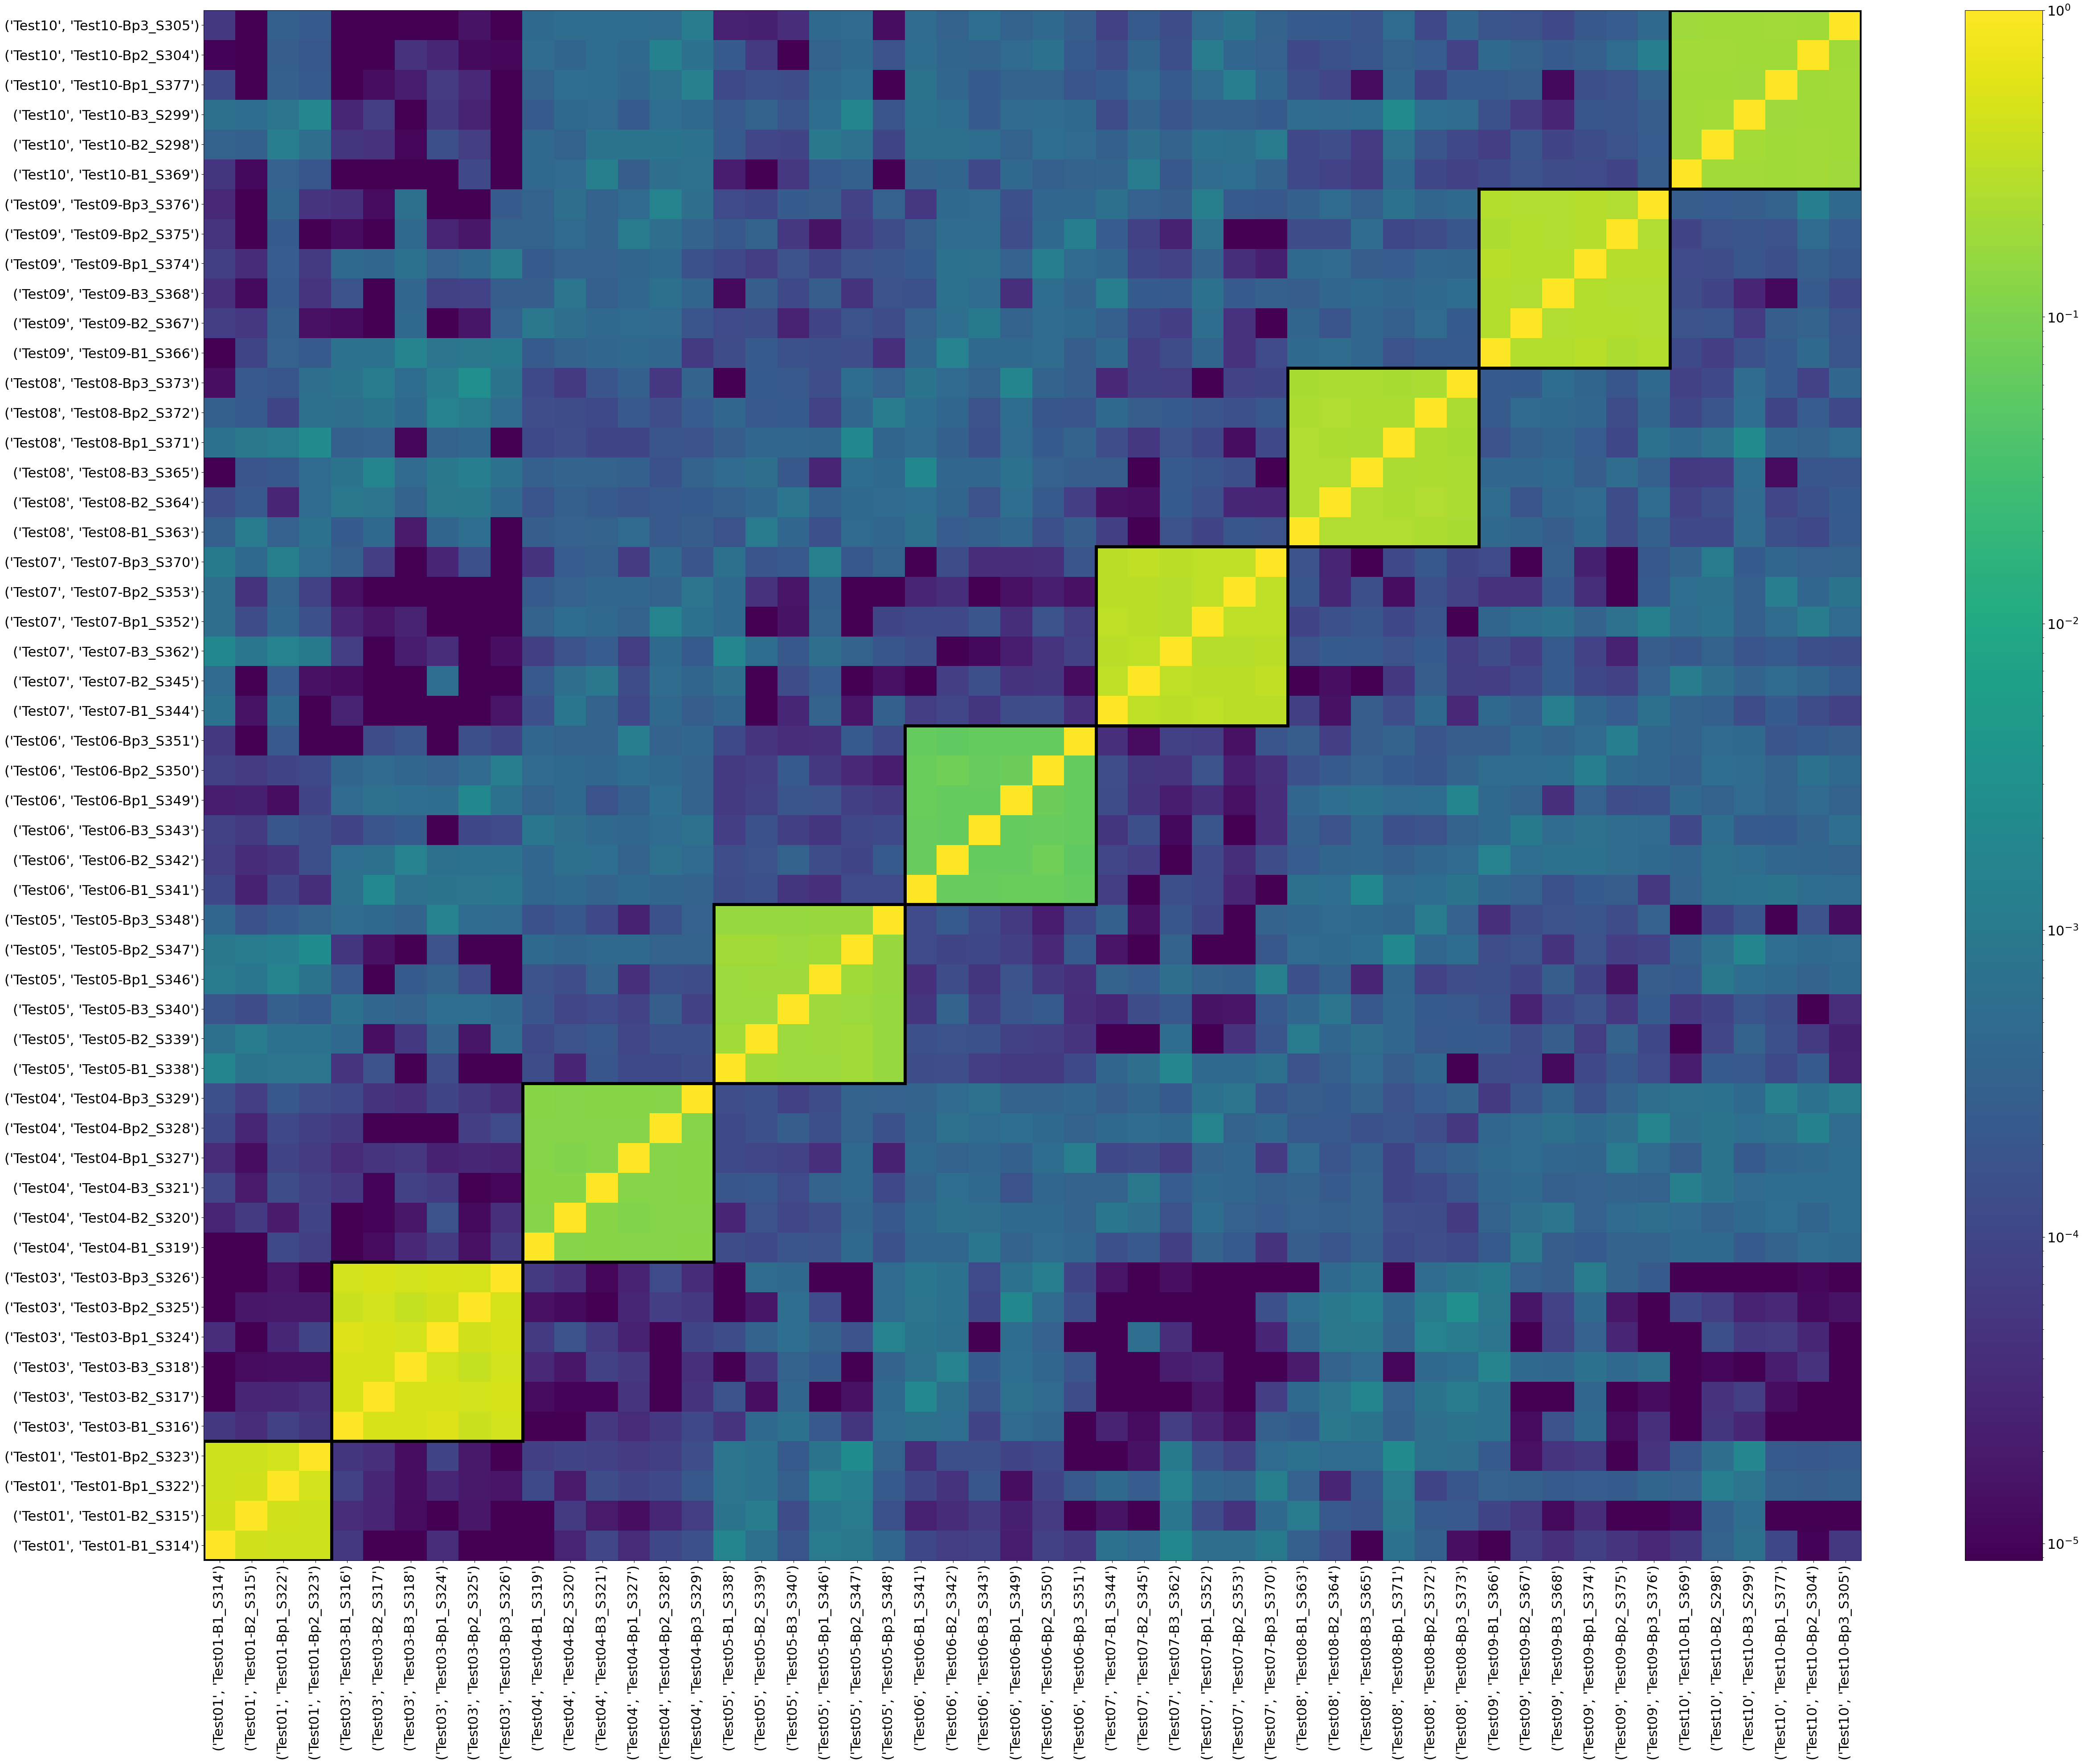

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.23794812056469802 0.12030816826927221
mean diff patient 0.0003088108357033717 0.0003431299828626036
threshold 0.0016813307671537862


{'whiskers': [<matplotlib.lines.Line2D at 0x7f12693af860>,
 'caps': [<matplotlib.lines.Line2D at 0x7f12693afe10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f12693af550>,
 'medians': [<matplotlib.lines.Line2D at 0x7f12693b8400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f12693b86d8>,
 'means': []}

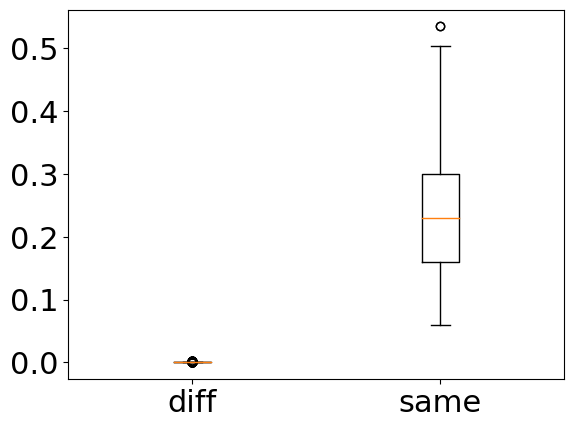

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

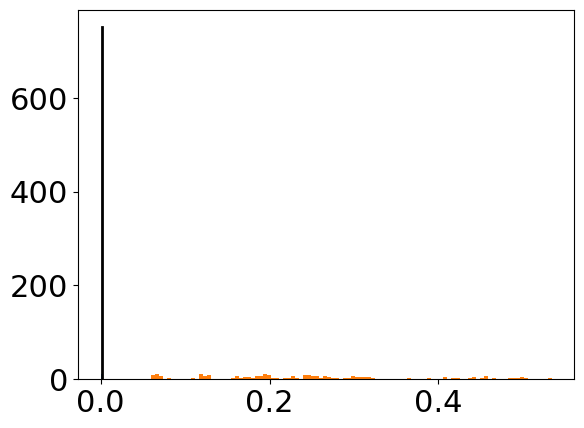

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('Test01', 'Test01-B1_S314') ('Test05', 'Test05-B1_S338') 0.0017260307005019238
('Test01', 'Test01-B1_S314') ('Test07', 'Test07-B3_S362') 0.002061747593171792
('Test01', 'Test01-Bp2_S323') ('Test05', 'Test05-Bp2_S347') 0.002300376705984042
('Test01', 'Test01-Bp2_S323') ('Test08', 'Test08-Bp1_S371') 0.002247839678669483
('Test01', 'Test01-Bp2_S323') ('Test10', 'Test10-B3_S299') 0.0019330317171369904
('Test03', 'Test03-B2_S317') ('Test06', 'Test06-B1_S341') 0.002078093977498363
('Test03', 'Test03-B2_S317') ('Test08', 'Test08-B3_S365') 0.0017898456092435566
('Test03', 'Test03-Bp2_S325') ('Test06', 'Test06-Bp1_S349') 0.0020618714155892226
('Test03', 'Test03-Bp2_S325') ('Test08', 'Test08-Bp3_S373') 0.0027130373239229177
('Test05', 'Test05-B1_S338') ('Test01', 'Test01-B1_S314') 0.0017260307005019238
('Test05', 'Test05-B1_S338') ('Test07', 'Test07-B3_S362') 0.0018071905822462098
('Test05', 'Test05-Bp2_S347') ('Test01', 'Test01-Bp2_S323') 0.002300376705984042
('Test05', 'Test05-Bp2_S347') ('Te

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 8.816126458532914e-06
max value: 1.0
Wrote run54-similarity-IGH_HUMAN-highlighted.pdf to disk


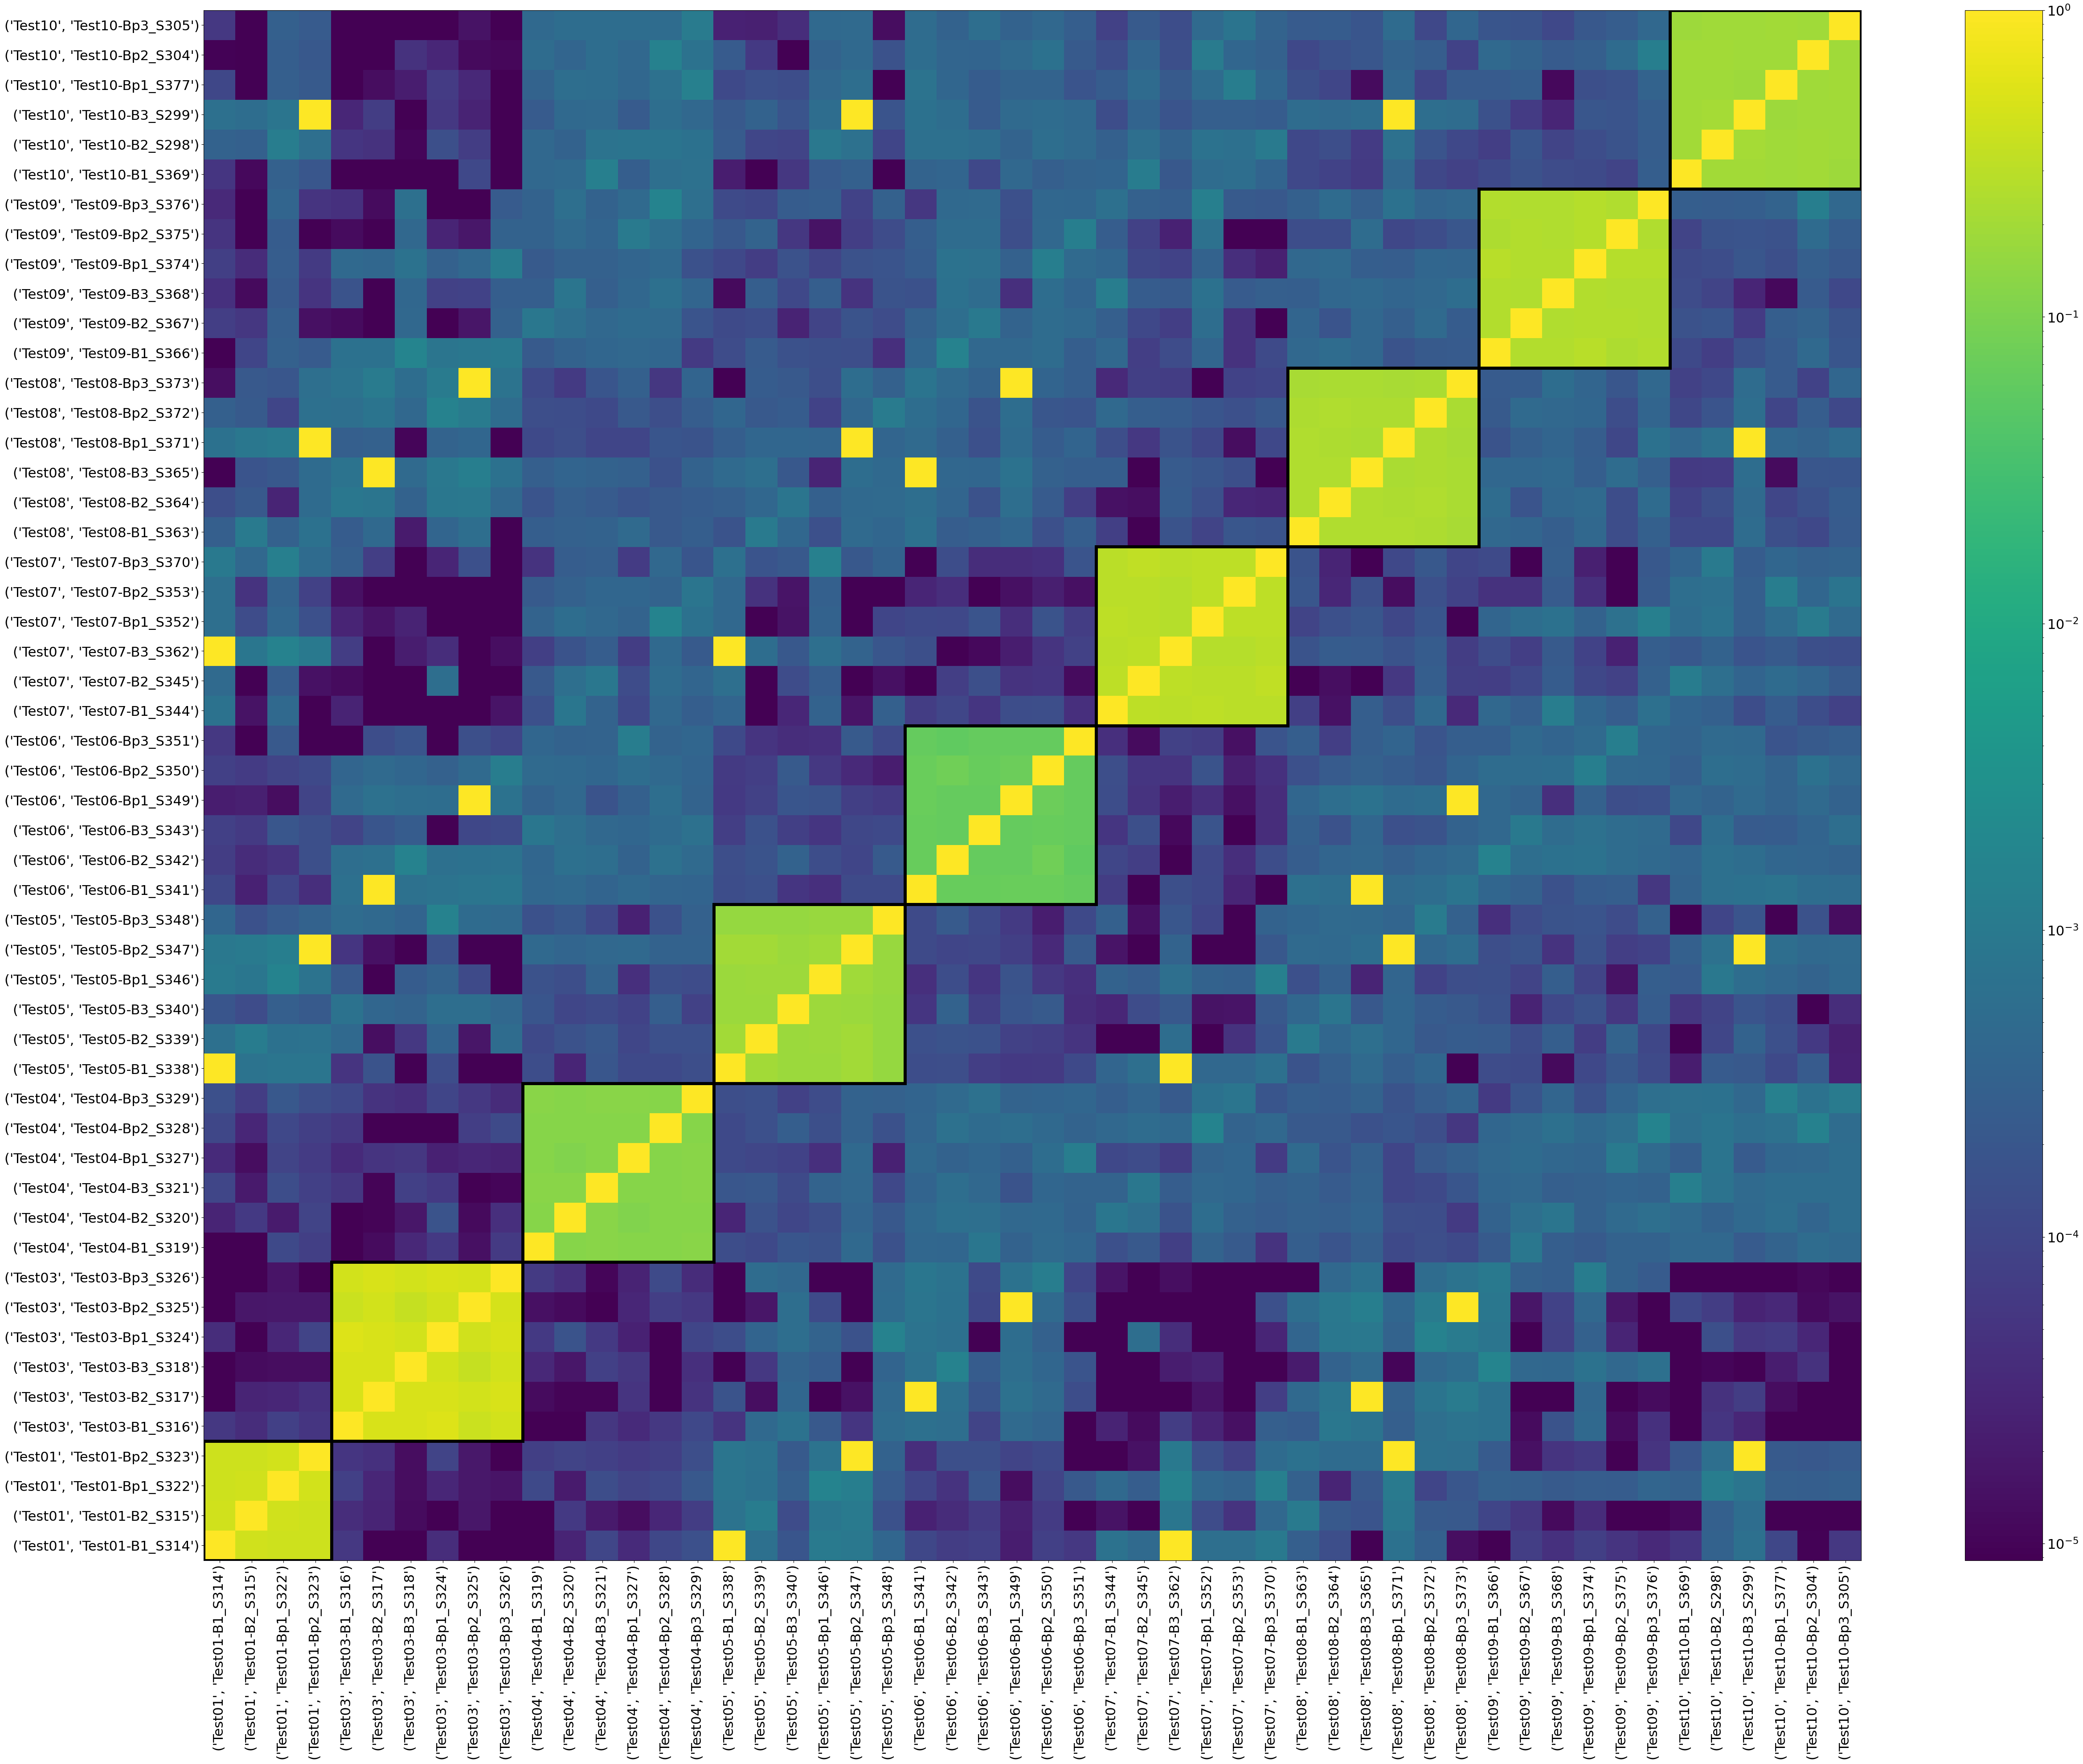

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)